In [211]:
# Cell 1: 导入依赖
import os
import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import math
from torchinfo import summary
from scipy.special import erfc

import matplotlib.pyplot as plt
from matplotlib import rcParams
# 设置支持中文的字体
rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 选择一个支持中文的字体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

#from configs import get_cfg
#from dataset import get_dataloader
#from model import VQVAE
#from pixelcnn_model import PixelCNNWithEmbedding

USE_LMDB = False


In [212]:
#预处理

# 1.读取 数据集文件

clean_data = np.load(r'dataset_isi_normalized\qpsk_clean.npy')

train_data = clean_data[0:100000]
# 打印数据的形状以确认
print(f"原始数据形状：{clean_data.shape}")

# 加噪
def add_awgn_noise_np(clean_data, EbN0_db):
    noisy_data = np.zeros(clean_data.shape)
    # 计算信号功率
    signal_power = np.mean((np.abs(clean_data[:,0,:]) ** 2) + (np.abs(clean_data[:,1,:]) ** 2))
    EbN0_linear = 10**(EbN0_db/10)
    N0 = signal_power / EbN0_linear
    noise_std = np.sqrt(N0/2)
    # 生成I/Q两路独立高斯噪声
    noise_I = noise_std * np.random.randn(*clean_data[:,0,:].shape)
    noise_Q = noise_std * np.random.randn(*clean_data[:,1,:].shape)
    
    # 加噪（模拟实际信道）
    noisy_data[:,0,:] = clean_data[:,0,:] + noise_I;  # I路接收信号
    noisy_data[:,1,:] = clean_data[:,1,:] + noise_Q;  # Q路接收信号

    return noisy_data

def add_awgn_noise_torch(clean_data, EbN0_db):
    """
    clean_data: [batch, 2, length]  torch.Tensor (float, 可在 GPU 上)
    EbN0_db: 信噪比
    返回加噪后的信号，类型和设备与输入相同
    """
    # 计算信号功率 (I/Q 平均)
    signal_power = (clean_data[:,0,:].pow(2) + clean_data[:,1,:].pow(2)).mean()

    # 计算噪声功率
    EbN0_linear = 10 ** (EbN0_db / 10)
    N0 = signal_power / EbN0_linear
    noise_std = torch.sqrt(N0/2)

    # 生成 I/Q 两路独立高斯噪声
    noise_I = noise_std * torch.randn_like(clean_data[:,0,:])
    noise_Q = noise_std * torch.randn_like(clean_data[:,1,:])

    # 加噪
    noisy_data = clean_data.clone()
    noisy_data[:,0,:] += noise_I
    noisy_data[:,1,:] += noise_Q

    return noisy_data



原始数据形状：(120000, 2, 48)


In [213]:
class Dataset(Dataset):
    def __init__(self, start_samples, end_samples, seq_len=48, n_channels=2, n_classes=4):
        self.x = np.load(r'dataset_isi_normalized\qpsk_clean.npy')
        self.y = np.load(r'dataset_isi_normalized\qpsk_clean.npy')
        self.x = self.x[start_samples:end_samples]
        self.y = self.y[start_samples:end_samples]


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [214]:
def get_signal_shape():
    return (2, 48)  # 2个通道，长度为48的信号

class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len: int, d_model: int):
        super().__init__()

        # Assume d_model is an even number for convenience
        assert d_model % 2 == 0

        pe = torch.zeros(max_seq_len, d_model)
        i_seq = torch.linspace(0, max_seq_len - 1, max_seq_len)
        j_seq = torch.linspace(0, d_model - 2, d_model // 2)
        pos, two_i = torch.meshgrid(i_seq, j_seq)
        pe_2i = torch.sin(pos / 10000**(two_i / d_model))
        pe_2i_1 = torch.cos(pos / 10000**(two_i / d_model))
        pe = torch.stack((pe_2i, pe_2i_1), 2).reshape(max_seq_len, d_model)

        self.embedding = nn.Embedding(max_seq_len, d_model)
        self.embedding.weight.data = pe
        self.embedding.requires_grad_(False)

    def forward(self, t):
        return self.embedding(t)

class UnetBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, residual=False):
        super().__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv1d(in_c, out_c, 3, 1, 1)
        self.conv2 = nn.Conv1d(out_c, out_c, 3, 1, 1)
        self.activation = nn.ReLU()
        self.residual = residual
        if residual:
            if in_c == out_c:
                self.residual_conv = nn.Identity()
            else:
                self.residual_conv = nn.Conv1d(in_c, out_c, 1)

    def forward(self, x):
        out = self.ln(x)
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        if self.residual:
            out += self.residual_conv(x)
        out = self.activation(out)
        return out


class UNet(nn.Module):
    def __init__(self, n_steps, channels=[10, 20, 40, 80], pe_dim=10, residual=False):
        super().__init__()
        # C: Input channel size, H: Input length (signal length)
        C, H = get_signal_shape()  # 2, 48 
        layers = len(channels)
        Hs = [H]
        cH = H
        for _ in range(layers - 1):
            cH //= 2
            Hs.append(cH)

        self.pe = PositionalEncoding(n_steps, pe_dim)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pe_linears_en = nn.ModuleList()
        self.pe_linears_de = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        prev_channel = C
        for channel, cH in zip(channels[0:-1], Hs[0:-1]):
            self.pe_linears_en.append(
                nn.Sequential(nn.Linear(pe_dim, prev_channel), nn.ReLU(),
                              nn.Linear(prev_channel, prev_channel)))
            self.encoders.append(
                nn.Sequential(
                    UnetBlock((prev_channel, cH),
                              prev_channel,
                              channel,
                              residual=residual),
                    UnetBlock((channel, cH),
                              channel,
                              channel,
                              residual=residual)))
            self.downs.append(nn.Conv1d(channel, channel, 2, 2))
            prev_channel = channel

        self.pe_mid = nn.Linear(pe_dim, prev_channel)
        channel = channels[-1]
        self.mid = nn.Sequential(
            UnetBlock((prev_channel, Hs[-1]),
                      prev_channel,
                      channel,
                      residual=residual),
            UnetBlock((channel, Hs[-1]),
                      channel,
                      channel,
                      residual=residual),
        )
        prev_channel = channel
        for channel, cH in zip(channels[-2::-1], Hs[-2::-1]):
            self.pe_linears_de.append(nn.Linear(pe_dim, prev_channel))
            self.ups.append(nn.ConvTranspose1d(prev_channel, channel, 2, 2))
            self.decoders.append(
                nn.Sequential(
                    UnetBlock((channel * 2, cH),
                              channel * 2,
                              channel,
                              residual=residual),
                    UnetBlock((channel, cH),
                              channel,
                              channel,
                              residual=residual)))

            prev_channel = channel

        self.conv_out = nn.Conv1d(prev_channel, C, 3, 1, 1)

    def forward(self, x, t):
        n = t.shape[0]
        t = self.pe(t)
        encoder_outs = []
        for pe_linear, encoder, down in zip(self.pe_linears_en, self.encoders,
                                            self.downs):
            pe = pe_linear(t).reshape(n, -1, 1)
            x = encoder(x + pe)
            encoder_outs.append(x)
            x = down(x)
        pe = self.pe_mid(t).reshape(n, -1, 1)
        x = self.mid(x + pe)
        for pe_linear, decoder, up, encoder_out in zip(self.pe_linears_de,
                                                       self.decoders, self.ups,
                                                       encoder_outs[::-1]):
            pe = pe_linear(t).reshape(n, -1, 1)
            x = up(x)

            pad_x = encoder_out.shape[2] - x.shape[2]
            x = F.pad(x, (pad_x // 2, pad_x - pad_x // 2))
            x = torch.cat((encoder_out, x), dim=1)
            x = decoder(x + pe)
        x = self.conv_out(x)
        return x
    

In [215]:
class DDPM():
    def __init__(self,
                 device,
                 n_steps: int,
                 min_alpha_bar: float = 0.6):  # 起始alpha_bar稍微小一点
        # 线性 alpha_bar 调度 (从 min_alpha_bar → 0)
        alpha_bars = torch.linspace(min_alpha_bar, 0.0, n_steps).to(device)
        alphas = torch.empty_like(alpha_bars)
        betas = torch.empty_like(alpha_bars)

        alphas[0] = alpha_bars[0]
        betas[0] = 1 - alphas[0]
        for t in range(1, n_steps):
            alphas[t] = alpha_bars[t] / alpha_bars[t-1]
            betas[t] = 1 - alphas[t]

        self.betas = betas
        self.alphas = alphas
        self.alpha_bars = alpha_bars
        self.n_steps = n_steps

    def sample_forward(self, x, t, eps=None):
        """
        正向扩散过程: 通过将噪声加到输入信号 x 上。
        """
        alpha_bar = self.alpha_bars[t].to(x.device).reshape(-1, 1, 1)
        if eps is None:
            eps = torch.randn_like(x)
        res = eps * torch.sqrt(1 - alpha_bar) + torch.sqrt(alpha_bar) * x
        return res

    def sample_backward(self, x0, net, device, simple_var=True):
        """
        从一个加噪信号 (随机时间步t) 开始反向去噪，而不是从纯噪声开始。
        x0: 干净信号 (batch_size, ...)
        """
        n = x0.shape[0]
        net = net.to(device)

        # 1. 随机选择每个样本的时间步 t
        t = torch.randint(low=1, high=self.n_steps, size=(1,), device=device)

        # 2. 在选定的 t 上加噪得到 x_t
        x_t = self.sample_forward(x0, t)
        noisy_data = x_t
        # 3. 从该 t 开始逐步反推到 x_0
        for step in reversed(range(t.max().item() + 1)):  # 从最大t逐步回到0
            # mask: 只更新还没完成的样本
            mask = (t >= step).float().view(-1, *([1] * (x_t.ndim - 1)))
            if mask.sum() == 0:
                continue
            x_t = self.sample_backward_step(x_t, step, net, simple_var) * mask + x_t * (1 - mask)

        return x_t, noisy_data 

    def sample_backward_step(self, x_t, t, net, simple_var=True):
        """
        反向去噪的每一步：根据当前时间步的噪声预测和相应的方差进行信号更新。
        """
        n = x_t.shape[0]
        # 确保 t 是 1D long tensor 并且在 x_t.device 上
        t_tensor = torch.full((n,), t, dtype=torch.long, device=x_t.device)

        eps = net(x_t, t_tensor)

        if t == 0:
            noise = 0  # No noise at t=0
        else:
            if simple_var:
                var = self.betas[t]
            else:
                var = (1 - self.alpha_bars[t - 1]) / (1 - self.alpha_bars[t]) * self.betas[t]
            noise = torch.randn_like(x_t)
            noise *= torch.sqrt(var)

        mean = (x_t - (1 - self.alphas[t]) / torch.sqrt(1 - self.alpha_bars[t]) * eps) / torch.sqrt(self.alphas[t])
        x_t = mean + noise

        return x_t

In [216]:


epoch_num = 100
# 实例化
model = UNet(n_steps=50)
ddpm = DDPM(device='cuda', n_steps=50)
# 选择设备

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将模型加载到设备（GPU或CPU）
model = model.to(device)

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4)

# 损失函数
mse_loss = nn.MSELoss()    # 判别器对应 Sigmoid，分类任务计算二元交叉熵损失


In [217]:
#4. 准备数据
# ==========================
train_data = Dataset(0, 100000)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_set, val_set = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)


Epoch [1/100] Train Loss: 0.0732, Val Loss: 0.0351
✅ 验证损失下降，保存模型
[-0.35885897  0.7846862   0.6454067   0.75103766 -0.03652073  0.24179937
  0.00240436 -0.24710602  0.80477965 -0.03991589  0.5038781   0.04929143
  0.43775025  0.23324043  0.04995985  0.12624118 -0.1474575  -0.18962976
 -0.12229923  1.4406838   0.68612134 -0.04873582  0.18179666  0.40731284
  0.21715832  0.2305968   0.32150823  0.3451218   0.69562525  0.36048013
  0.5894333   0.33560798  0.41614258  0.6601839   0.67998564  0.7283147
 -0.27154478  0.52270377 -0.07835966  0.17045707  0.34877515  0.8926279
  0.00643419  0.13487612  0.8363548  -0.01326409 -0.02430727 -0.15187506]


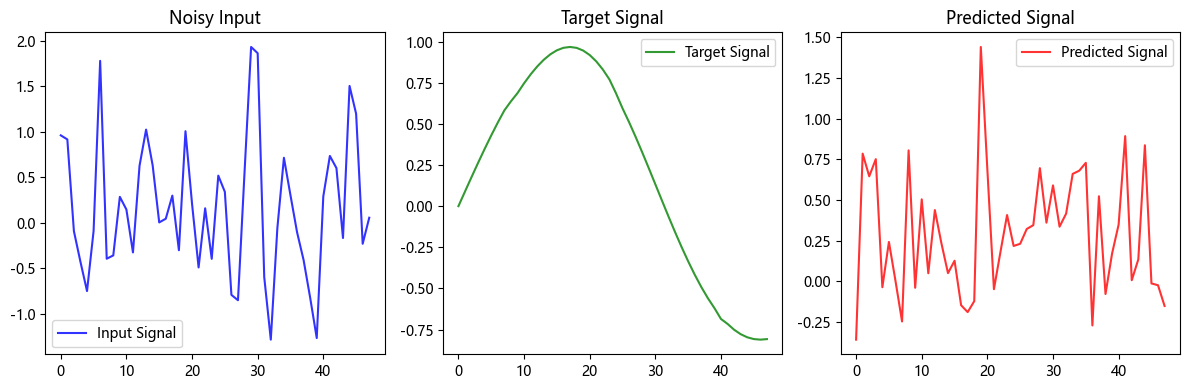

Epoch [2/100] Train Loss: 0.0351, Val Loss: 0.0330
✅ 验证损失下降，保存模型
Epoch [3/100] Train Loss: 0.0340, Val Loss: 0.0335
⚠️ 验证损失没有下降 (1/10)
[ 0.43726143 -0.10860677  0.58961606  1.0347105   0.5310103  -0.20307942
  1.3471124   0.9879964   0.11985323  1.2246307  -0.2037164  -0.46771172
  0.0701327   0.14568323 -0.35442522  0.35662043  0.28154856  0.67092586
  0.76076126  1.1108742   0.61257625 -0.02645119  0.8630487  -0.19440277
  0.8908532   1.3625876   0.3702291   0.07579067  0.97791755  0.26291347
 -0.1748285   0.21600355  0.29305774  0.43362427  0.4123901   0.7805563
 -0.23499905  0.7436411  -1.022101   -0.1881341  -0.5476252  -0.6305076
  0.57495445  1.09162     0.53114915  0.53553516  0.03061569 -0.08175344]


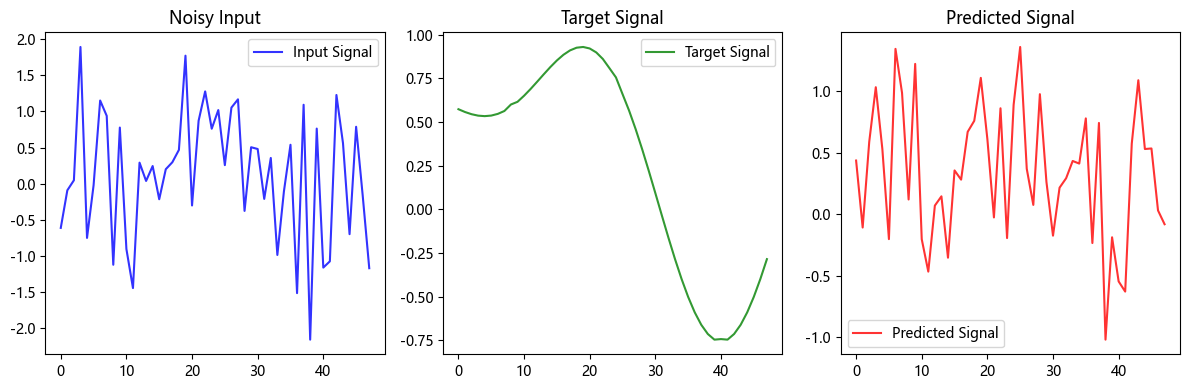

Epoch [4/100] Train Loss: 0.0338, Val Loss: 0.0334
⚠️ 验证损失没有下降 (2/10)
Epoch [5/100] Train Loss: 0.0334, Val Loss: 0.0333
⚠️ 验证损失没有下降 (3/10)
[-0.727758   -1.1229537  -0.4714076  -0.6378593  -0.9560903  -0.8996233
 -0.6134434  -0.34586632 -0.19758327 -0.21168831 -0.18427113 -0.6693545
 -0.50109386 -0.7648628  -0.45845956 -0.61561704 -0.1899406  -0.10750485
 -0.7729725   0.0842923  -0.15444717 -0.6141262  -0.26649857 -0.25285202
 -0.33193672 -0.22811638  0.28755802 -0.3924002  -0.22784376  0.12843879
 -0.8305921  -0.41344646 -0.24302965 -0.46110138 -0.12193649 -0.00636378
 -0.34216875 -0.6207885  -0.3546529  -0.68850887 -0.54938805  0.1258866
 -1.1773727  -0.3284437  -0.4763526  -0.7361353  -0.5311014  -0.5364506 ]


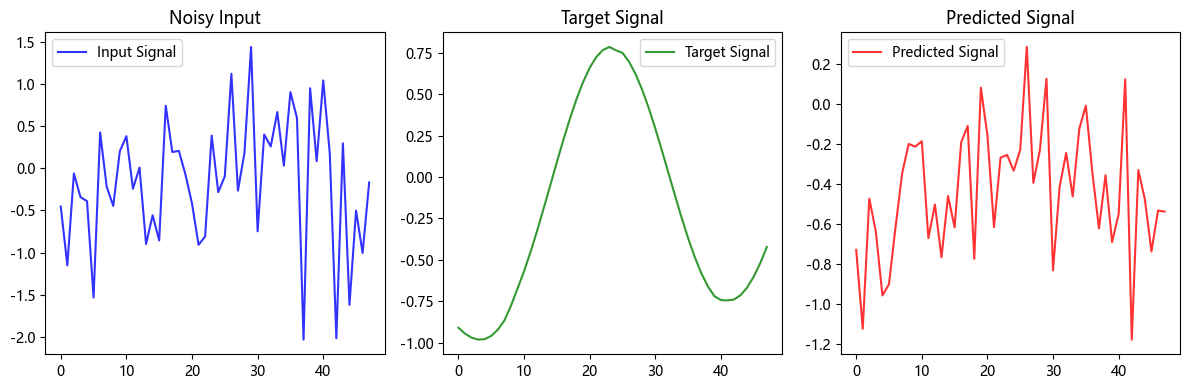

KeyboardInterrupt: 

In [218]:
# ----------训练循环----------
# ----------SNR 相关设置----------
snr_range = np.arange(-15, 8, 1)  # 训练时的 SNR 范围
snr_min = -15    # 初始最低 SNR
snr_max = 8   # 最高 SNR
curriculum_epochs = 10  # 前 curriculum_epochs 个 epoch 逐渐增加难度
n_steps = ddpm.n_steps

train_losses, val_losses = [], []
patience = 10
best_val_loss = float("inf")
early_stop_counter = 0

for epoch in range(epoch_num):
    # ----------训练阶段----------
    model.train()
    total_loss = 0
    
    for x, y in train_loader:
        x = x.float().to(device)
        y = y.float().to(device)

        current_batch_size = x.shape[0]
        # 为当前批次添加随机 SNR 噪声
        snr = random.uniform(snr_min, snr_max)
        #x_noisy = add_awgn_noise_torch(x, snr)
        
        t = torch.randint(0, n_steps, (current_batch_size, )).to(device)
        eps = torch.randn_like(x).to(device)
        x_t = ddpm.sample_forward(x, t, eps)
        t_prev = torch.clamp(t-1, min=0)
        x_t_1 = ddpm.sample_forward(x, t_prev, eps)

        x_hat = model(x_t, t.reshape(current_batch_size, 1))
        loss = mse_loss(x_hat, x_t_1)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ----------验证阶段----------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            
            x = x.float().to(device)
            y = y.float().to(device)

            
            if x.size(0) != 64:  # 假设标准批大小为64
                pad_size = 64 - x.size(0)
                # 在 batch 维度补 pad_size 个样本
                x = torch.cat([x, torch.zeros(pad_size, *x.shape[1:], device=x.device)], dim=0)
            current_batch_size = x.shape[0]
            # 验证集也随机选择 SNR
            # 为当前批次添加随机 SNR 噪声
            snr = random.uniform(snr_min, snr_max)
            #x_noisy = add_awgn_noise_torch(x, snr)
            
            t = torch.randint(0, n_steps, (current_batch_size, )).to(device)
            eps = torch.randn_like(x).to(device)
            x_t = ddpm.sample_forward(x, t, eps)
            t_prev = torch.clamp(t-1, min=0)
            x_t_1 = ddpm.sample_forward(x, t_prev, eps)

            x_hat = model(x_t, t.reshape(current_batch_size, 1))
            loss = mse_loss(x_hat, x_t_1)

            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epoch_num}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # ----------早停与模型保存----------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_Ds_model.pth")
        print(f"✅ 验证损失下降，保存模型")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"⚠️ 验证损失没有下降 ({early_stop_counter}/{patience})")
        if early_stop_counter >= patience:
            print("⏹️ 早停触发，停止训练。")
            break

    # ----------可视化验证集波形输出----------

    if epoch % 2 == 0:
        with torch.no_grad():
            sample_input, sample_target = next(iter(val_loader))
            snr = random.uniform(snr_min, snr_max)
            sample_input = sample_input.float().to(device)
            # 添加噪声
            #sample_input_noisy = add_awgn_noise_torch(sample_input.float().to(device), snr)
            
            batch_size = sample_input.size(0)   # 批大小
            #signal_shape = (batch_size, *get_signal_shape())  # tuple of ints 
            
            # 生成预测波形
            sample_output, noisy_data = ddpm.sample_backward(sample_input,   
                                                model,
                                                device=device,
                                                simple_var=True)
            sample_output = sample_output.detach().cpu()
            noisy_data = noisy_data.detach().cpu()
            sample_target = sample_target.float().cpu()   # 直接放 CPU，方便绘图
            
            # 随机选取一个样本
            data_idx = random.randint(0, batch_size - 1)

            # 开始绘图
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.plot(noisy_data[data_idx, 0, :].cpu().numpy(), 
                    label="Input Signal", color="blue", alpha=0.8)
            plt.title("Noisy Input")
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(sample_target[data_idx, 0, :].numpy(), 
                    label="Target Signal", color="green", alpha=0.8)
            plt.title("Target Signal")
            plt.legend()
            
            #print(sample_output[data_idx, 0, :].numpy())
            plt.subplot(1, 3, 3)
            plt.plot(sample_output[data_idx, 0, :].numpy(), 
                    label="Predicted Signal", color="red", alpha=0.8)
            plt.title("Predicted Signal")
            plt.legend()

            plt.tight_layout()
            plt.show()

In [ ]:
#7. 可视化 Loss
# ==========================
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

In [ ]:
#标签数据
label = np.load(r'dataset_isi_normalized\qpsk_labels.npy')  

label_data = label[100000:]

# 创建一个空的数组label_data_IQ，形状为(120000, 2)
label_data_IQ = np.zeros((len(label_data), 2), dtype=int)
# 遍历label_data，根据每个标签值更新label_data_IQ
for i in range(len(label_data)):
    if label_data[i] == 0:
        label_data_IQ[i][0] = 0
        label_data_IQ[i][1] = 0
    elif label_data[i] == 1:
        label_data_IQ[i][0] = 0
        label_data_IQ[i][1] = 1
    elif label_data[i] == 2:
        label_data_IQ[i][0] = 1
        label_data_IQ[i][1] = 1
    elif label_data[i] == 3:
        label_data_IQ[i][0] = 1
        label_data_IQ[i][1] = 0


In [ ]:
# 测试阶段

#模型去噪

def model_test(snrDB):
    test_data = Dataset(100000, 120000)
    test_data.x = add_awgn_noise_np(test_data.x, snrDB)

    test_set = test_data
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    # 加载训练好的生成器模型
    model = UNet(2, 32, 256)
    model.to(device)
    model.load_state_dict(torch.load('best_Ds_model.pth', map_location=device))
    model.eval()

    # 用于存储所有生成的结果
    all_generated = []

    # 关闭梯度计算
    with torch.no_grad():
        for x, y in test_loader:
            noise_input = x.to(device).float()  
            generated, ze, zq = model(noise_input)  # 生成器输出
            all_generated.append(generated.cpu().numpy())

    # 合并所有结果 (20000, ...)
    all_generated = np.concatenate(all_generated, axis=0)

    # 重构信号
    model_signal = np.zeros((len(all_generated)*16,), dtype=np.complex64)
    baseline_signal = np.zeros((len(all_generated)*16,), dtype=np.complex64)

    for i in range(len(all_generated)):
        model_signal[16*i:16*i+16] = all_generated[i, 0, 24:40] + 1j*all_generated[i, 1, 24:40]  # 取中间16个点
        baseline_signal[16*i:16*i+16] = test_data.x[i, 0, 24:40] + 1j*test_data.x[i, 1, 24:40]  # 取中间16个点 

    return  model_signal, baseline_signal


# 下采样
def downsample(signal, SAMPLES_PER_SYMBOL=16):
    return signal[::SAMPLES_PER_SYMBOL]

# 硬判决
def decision_making(downsampled_signal, threshold=0):

    real_part = np.real(downsampled_signal)
    imag_part = np.imag(downsampled_signal)

    decision = np.zeros((len(downsampled_signal),2), dtype=int)
    #print(real_part[:10])
    #print(imag_part[:10])
    for i in range(len(downsampled_signal)):
        if (real_part[i] > threshold) and (imag_part[i] > threshold):
            decision[i,0] = 0 
            decision[i,1] = 0
        elif (real_part[i] < threshold) and (imag_part[i] > threshold):
            decision[i,0] = 0 
            decision[i,1] = 1
        elif (real_part[i] < threshold) and (imag_part[i] < threshold):
            decision[i,0] = 1 
            decision[i,1] = 1
        elif (real_part[i] > threshold) and (imag_part[i] < threshold):
            decision[i,0] = 1
            decision[i,1] = 0
    #print(decision[:10])
    return decision

# 计算误码率
def calculate_ber(original_labels, predicted_labels):
    
    predicted_labels = predicted_labels.astype(int)

    
    #print(original_labels[:10])
    #print(predicted_labels[:10])
    error_num_i = 0
    error_num_q = 0
    error_num = 0
    
    error_num_i = np.sum(original_labels[:, 0] != predicted_labels[:, 0])
    error_num_q = np.sum(original_labels[:, 1] != predicted_labels[:, 1])

    error_num = error_num_i + error_num_q

    #print(error_num_i)
    #print(error_num_q)
    ber = error_num / (len(original_labels)*2)
    print(ber)
    return ber

# 接收器
def matched_filter_decision(labels, snr_db, SAMPLES_PER_SYMBOL=16):

    recovered_signal, baseline_signal = model_test(snr_db) 
    # 下采样
    #print(recovered_signal[:10])
    downsampled_model_signal = downsample(recovered_signal, SAMPLES_PER_SYMBOL)
    downsampled_baseline_signal = downsample(baseline_signal, SAMPLES_PER_SYMBOL)
    # 硬判决
    predicted_model_labels = decision_making(downsampled_model_signal)
    predicted_baseline_labels = decision_making(downsampled_baseline_signal)

    # 确保 labels 和 predicted_labels 都是扁平化的一维数组
    model_ber = calculate_ber(labels, predicted_model_labels)
    baseline_ber = calculate_ber(labels, predicted_baseline_labels)
    return model_ber, baseline_ber


In [ ]:
# 绘制BER曲线
def plot_ber_curve(output_re_bers, baseline_bers, snr_range):
    plt.figure(figsize=(12, 8))
    
    # 绘制模型BER曲线
    plt.semilogy(snr_range, output_re_bers, 'o-', label='Model')

    theoretical_bers = []
    for snr_db in snr_range:
        snr_db = snr_db + 10*math.log10(16)
        snr_linear = 10 ** (snr_db / 10)
        theoretical_bers.append(0.5 * erfc(np.sqrt(snr_linear/2)))

    # 绘制理论BER曲线
    plt.semilogy(snr_range, theoretical_bers, 'r--', label='匹配滤波器')
    theoretical_num = []
    for i in range(len(theoretical_bers)):
        theoretical_num.append(theoretical_bers[i])
    print(theoretical_num)
    # 关键：设置横轴仅显示偶数刻度
    min_snr = np.min(snr_range)
    max_snr = np.max(snr_range)

    # 绘制baseline
    plt.semilogy(snr_range, baseline_bers, 'v-', label='baseline')
    
    # 生成从 min_snr 到 max_snr 的偶数序列，np.arange 步长设为 2
    xticks = np.arange(np.ceil(min_snr / 2) * 2, np.floor(max_snr / 2) * 2 + 2, 2)
    plt.xticks(xticks)  

    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER')
    plt.title('Bit Error Rate vs. SNR (QPSK)')
    plt.legend()
    plt.show()



    

In [ ]:

model_bers = []
baseline_bers = []
for snr_db in snr_range:
    print(f"当前SNR: {snr_db} dB")
    model_ber, baseline_ber =  matched_filter_decision(label_data_IQ, snr_db)
        
    model_bers.append(model_ber)
    baseline_bers.append(baseline_ber)

#绘图
plot_ber_curve(model_bers, baseline_bers, snr_range)


        